<!-- [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb) -->
<a href="https://colab.research.google.com/drive/1ZE0L54UDA2p-vRZs79BvLDjEp6bMY9Ox#scrollTo=TZIZlv5Hs2e-&uniqifier=1" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Seminar 6: Deep Learning for fMRI**

## **Classification of full-size fMRI**

#### Introduction
In this notebook we will work with full-size fMRI data which represents 4D tensor or a 3D video of the brain functional activity.

**We will train a network for detection of Autistm Spectrum Disorder (ASD) based on full-size fMRI series.** 

**Also, we will apply a conventional domain adaptation approach to reduce the part of the site-related variability in the data.**

In [66]:
import os
import time
from tqdm import tqdm
import nibabel as nib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms

In [67]:
# check if gpu is available
!nvidia-smi

Fri Oct  2 10:55:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    37W / 300W |  13155MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [68]:
use_cuda = torch.cuda.is_available()
print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")
device = 0

Torch version: 1.6.0+cu101
Using GPU


Mounting Google Drive to Collab Notebook. You should go with the link and enter your personal authorization code:

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Get the data. Add a shortcut to your Google Drive.

Shared link: https://drive.google.com/drive/folders/1_63qnHOCUEzOUmUWhcmTXulmQMmJglwT?usp=sharing

(You will need the same data directory, as in the first part of the seminar)

We will use full-size fMRI series from the same data collection, that we analysed in the first part. However,  here we will only consider the data from **2** acquistion sites - **USM** and **UCLA** with around **70** participants from each. 


<!-- The diagnosis is labelled in **"DX_GROUP"** column and is either Autism spectrum disorder or Healthy control. -->

<!-- You may also see that data collection is composed of smaller datasets provided from several different medical centers and research institutes (see the **"SOURCE"** column). -->

In [70]:
folder_path = '/content/drive/My Drive/NeuroML/func_ABIDE/abide_fmri/'
targets_path = '/content/drive/My Drive/NeuroML/func_ABIDE/ABIDE1CPAC_targets.csv'

### Dataloader to load full-size fMRI data. 

Below you can see a Dataset class for loading full-size fMRI. 

What is implemented here:

- Collecting all the fMRI files from a given folder;
- Loading fMRI 4D time series from a `.nii` of `.npy` file;
- **Preloading** all the images into RAM or **loading them online** (`load_online` argument);
- **Cropping a brain image** to the given size, if needed (`coord_min` and `img_shape` arguments);
- **Taking a subsequence** of a given size starting from a given time step, or sampling at a random time step, if not given (`start_pos`, `seq_len` arguments).

In [7]:
def load_nii_to_array(nii_path):
    return np.asanyarray(nib.load(nii_path).dataobj)

class fMRIDataset(data.Dataset):
    """
    Arguments:
        folder_path: path to data folder
        labels_path: path to file with targets and additional information
        target: column of targets df with target to predict. If None, loads images only
        encode_target: if True, encode target with LabelEncoder
        mri_file_suffix (str): consider only files with given keyword in filename
        load_online (bool): if True, load mri images online. Else, preload everything during initialization
        transform (torchvision.transforms): if given, apply transformation to the item. If None, return item without modifications
    """
    
    def __init__(self, folder_path, labels_path, target=None, encode_target=False, domain_target=None,
                 mri_file_suffix="", load_online=False, transform=None,
                 source_col="SOURCE", use_sources=[],
                 coord_min=(6, 5, 6), img_shape=(48, 64, 48), 
                 start_pos=None, seq_len=None):
        self.mri_paths = {
            "participant_id" : [],
            "path" : [],
        }
        
        self.folder_path = folder_path
        self.labels = pd.read_csv(labels_path)
        self.target, self.domain_target = None, None
        self.load_online = load_online
        
        self.mri_file_suffix = mri_file_suffix
        self.source_col = source_col
        self.use_sources = use_sources

        self.coord_min = coord_min
        self.img_shape = img_shape
        self.start_pos = start_pos
        self.seq_len = seq_len
        self.transform = transform

        def get_participant_id(participant_file):
            return "sub-" + participant_file.split("_")[-4]
        
        participant_files = os.listdir(self.folder_path)
        for participant_file in tqdm(participant_files):
            if (self.mri_file_suffix in participant_file):
                # is participant file
                participant_path = os.path.join(self.folder_path, participant_file)
                participant_id = get_participant_id(participant_file)
                self.mri_paths["path"].append(participant_path)
                self.mri_paths["participant_id"].append(participant_id)
                            
        self.mri_paths = pd.DataFrame(self.mri_paths)
        self.labels = self.labels.merge(self.mri_paths, on="participant_id")
        self.mri_files = self.labels["path"].tolist()
        print(f"{len(self.mri_files)} image files found.")
        
        if not self.load_online:
            self.mri_files = [self.get_image(index, self.start_pos, self.seq_len) for index in tqdm(range(len(self.mri_files)))]

        # update self.img_shape (and other params ?)
        self.output_img_shape = self[0].shape[1:4]
        self.target, self.domain_target = self.set_target(target, encode_target, domain_target)
        
    
    def set_target(self, target=None, encode_target=False, domain_target=None):
        self.target, self.domain_target = None, None
        if target is not None:
            self.target = self.labels[target].copy()
            if (self.source_col is not None) and self.use_sources:
                # preserve only targets for objects from sources of interest
                null_idx = ~self.labels[self.source_col].isin(self.use_sources)
                self.target[null_idx] = np.nan
            if encode_target:
                enc = LabelEncoder()
                idx = self.target.notnull()
                self.target[idx] = enc.fit_transform(self.target[idx])
            if domain_target is not None:
                self.domain_target = self.labels[domain_target].copy()
                if (self.source_col is not None) and self.use_sources:
                    # preserve only targets for objects from sources of interest
                    null_idx = ~self.labels[self.source_col].isin(self.use_sources)
                    self.domain_target[null_idx] = np.nan
                self.domain_enc = LabelEncoder()
                idx = self.domain_target.notnull()
                self.domain_target[idx] = self.domain_enc.fit_transform(self.domain_target[idx])
        return self.target, self.domain_target

            
    def reshape_image(self, mri_img, coord_min, img_shape):
        seq_len = mri_img.shape[-1]
        return mri_img[coord_min[0]:coord_min[0] + img_shape[0],
                        coord_min[1]:coord_min[1] + img_shape[1],
                        coord_min[2]:coord_min[2] + img_shape[2], :].reshape((1,) + img_shape + (seq_len,))
        
    def get_image(self, index, start_pos=None, seq_len=None):
        
        def load_mri(mri_file):
            if "nii" in mri_file:
                img = load_nii_to_array(mri_file)
            else:
                img = np.load(mri_file)
            return img
        
        mri_file = self.mri_files[index]
        img = load_mri(mri_file)        
        img = self.reshape_image(img, self.coord_min, self.img_shape)
        
        if seq_len is None:
            seq_len = img.shape[-1]
        if start_pos is None:
            start_pos = np.random.choice(np.arange(img.shape[-1] - seq_len + 1))
        if seq_len == 1:
            img = img[:, :, :, :, start_pos]
        else:
            img = img[:, :, :, :, start_pos:start_pos + seq_len]
            img = img.transpose((4, 0, 1, 2, 3))
        return img
    
    def __getitem__(self, index):
        if (self.source_col is not None) and self.use_sources:
            s = self.labels[self.source_col][index]
            if s not in self.use_sources:
                return None

        img = self.get_image(index, self.start_pos, self.seq_len) if self.load_online else self.mri_files[index]
        if self.transform is not None:
            img = self.transform(img)

        if self.target is None:
            item = img
        else:
            item = [img, self.target[index]]
            if self.domain_target is not None:
                item += [self.domain_target[index]]
        return item

    def __len__(self):
        return len(self.mri_files)


<!-- 2. Individually normalizing each image to have given `min` and `max` values (here **0** and **1**). -->


Transforms are applied to each image returned by `fMRIDataset` object. For now, we will only need to transform the fMRI image from `np.array` to `torch.tensor`. 
However, you can implement additional transformation to add various types of augmentations. 

In [71]:
# transforms
import warnings

class ToTensor(object):
    def __call__(self, img):
        return torch.FloatTensor(img)

### Load data

Create a dataset that loads data from `func_ABIDE/abide_fmri`.

In general, fMRI sequences are too large, so we cannot process the whole sequence with neural network on GPU. A common practice is to **select random subsequences at the training** stage, and at the testing,  to split the sequence into several parts and **average the predictions** over them.

However, now, for faster training, we will use a prepared dataset of short subsequences from **0**th to **16**th time step of each series.

In [9]:
# create the dataset and load fMRI sequences

folder_path = '/content/drive/My Drive/NeuroML/func_ABIDE/abide_fmri'
targets_path = '/content/drive/My Drive/NeuroML/func_ABIDE/ABIDE1CPAC_targets.csv'

transform = transforms.Compose([
    ToTensor(),
])

dataset = fMRIDataset(
    folder_path, 
    labels_path=targets_path,
    target=None,
    mri_file_suffix="npy",
    load_online=False,
    transform=transform,
    source_col="SOURCE",
    use_sources=["USM", "UCLA"],
    start_pos=0,
    seq_len=16,
)

  0%|          | 0/145 [00:00<?, ?it/s]

145 image files found.


100%|██████████| 145/145 [02:19<00:00,  1.04it/s]


Take a look at the data. We will plot a brain image for a single time step. High-intensity values ​​correspond to strong brain activity in a given region.

torch.Size([16, 1, 48, 64, 48])


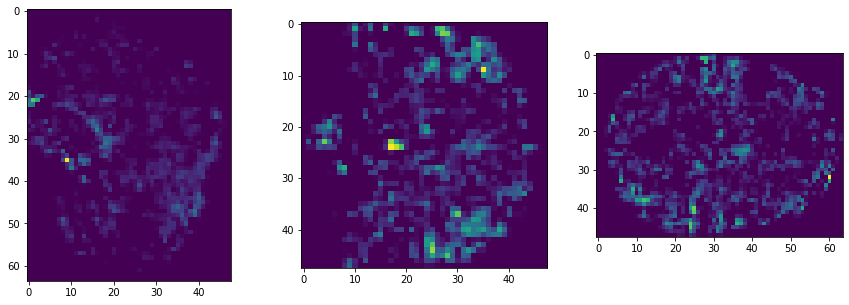

In [10]:
img = dataset[0]
print(img.shape)

img_t = img[0, 0,]
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(img_t[img_t.shape[0] // 2, :, :])
plt.subplot(132)
plt.imshow(img_t[:, img_t.shape[1] // 2, :])
plt.subplot(133)
plt.imshow(img_t[:, :, img_t.shape[2] // 2])
plt.show()

## **ConvTempNet for 4D full-size fMRI**

Now, we will train a ConvTempNet model to analyze this data and distinguish **patients with autism spectrum disorder** from the **healthy control group**. 

First, remind that ConvTempNet arhitecture consisits of two parts - convolutional and recurrent. It allows us to first extract vector of spatial features from each 3D brain image with **3D CNN**, and then process this sequence of vectors with **RNN** (or another suitable model, for example, temporal convoltions) to capture temporal patterns. 

### Convolutional blocks

**ConvEncoder** is an intermediate model, that extracts vector of spatial features from each 3D image in fMRI sequence and returns sequence of feature vectores. 

In [72]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class CNN3d(nn.Module):
    def __init__(self, 
                 input_shape=(64, 64, 64), 
                 n_outputs=None, 
                 conv_model=[32, 64, 128, 256], 
                 n_flatten_units=None):
        super(self.__class__, self).__init__()
        input_shape = np.array(input_shape)
        self.n_layers = len(conv_model)
        
        self.model = []
        C_in = 1
        for C_out in conv_model:
            self.model += [
                nn.Conv3d(C_in, C_out, 4, 2, 1, bias=False),
                nn.BatchNorm3d(C_out),
                nn.ReLU(inplace=True),
            ]
            C_in = C_out
            
        self.model += [Flatten()]
        print("n activations:", C_out,
              "of size:", list(input_shape // (2 ** self.n_layers)))
        self.n_flatten_units = int(np.prod(input_shape // (2 ** self.n_layers)) * C_out)
        print("n flatten units:", self.n_flatten_units)
        if n_outputs is not None:
            self.model += [
                nn.Linear(self.n_flatten_units, n_outputs)
            ]
        self.model = nn.Sequential(*self.model)
    
    def forward(self, x):
        return self.model(x)
    

class ResBlock3d(nn.Module):
    def __init__(self, C):
        super(self.__class__, self).__init__()
        self.C = C
        self.block = [
                nn.BatchNorm3d(C),
                nn.ReLU(inplace=True),
                nn.Conv3d(C, C, kernel_size=3, padding=1),
            ]
        self.block = nn.Sequential(*self.block)
        
    def forward(self, x):
        return x + self.block(x)
    

class ResNet3d(nn.Module):
    def __init__(self, 
                 input_shape=(64, 64, 64), 
                 n_outputs=None, 
                 conv_model=[32, 64, 128, 256], 
                 n_flatten_units=None):
        super(self.__class__, self).__init__()
        input_shape = np.array(input_shape)
        self.n_layers = len(conv_model)
        
        self.model = []
        C_in = 1
        for C_out in conv_model:
            # here instead of 3x3-BN-ReLU
            # we use 1x1-ResBlock3d-1x1 (1x1-BN-ReLU-3x3-1x1)
            self.model += [
                nn.Conv3d(C_in, C_out, 1, 1, 0, bias=False), # 1x1, add channels
                ResBlock3d(C_out),
                nn.Conv3d(C_out, C_out, 1, 2, 0, bias=False), # 1x1 reduce spatial dim
            ]
            C_in = C_out
            
        self.model += [Flatten()]
        print("n activations:", C_out,
              "of size:", list(input_shape // (2 ** self.n_layers)))
        self.n_flatten_units = int(np.prod(input_shape // (2 ** self.n_layers)) * C_out)
        print("n flatten units:", self.n_flatten_units)
        if n_outputs is not None:
            self.model += [
                nn.Linear(self.n_flatten_units, n_outputs)
            ]
        self.model = nn.Sequential(*self.model)
        
    def forward(self, x):
        return self.model(x)


class ConvEncoder(nn.Module):
    def __init__(self, input_shape=(64, 64, 64),
                 conv_model=[32, 64, 128, 256], conv_model_type="CNN",
                 n_flatten_units=None):
        super(self.__class__, self).__init__()
        self.conv_model_type = conv_model_type
        if conv_model_type == "CNN":
            self.conv_model = CNN3d(
                input_shape, None, 
                conv_model, n_flatten_units, 
            )
        elif conv_model_type == "ResNet":
            self.conv_model = ResNet3d(
                input_shape, None, 
                conv_model, n_flatten_units, 
            )
        
    def forward(self, x):
        n_objects, seq_length = x.size()[0:2]
        x = x.reshape([n_objects * seq_length] + list(x.size()[2:]))
        x = self.conv_model(x)
        x = x.reshape([n_objects, seq_length, -1])
        return x

###  ClfGRU model

**ClfGRU** is a recurrent model with GRU units, that takes sequence of feature vectors (in our case, extracted by ConvEncoder) and predicts the target variable. 

In [74]:
class ConvGRU(nn.Module):
    def __init__(self, n_latent_units, seq_length, n_outputs, 
                 hidden_size=128, n_layers=1,
                 n_fc_units=128, use_states="last", dropout=0):
        super(self.__class__, self).__init__()
        self.n_latent_units = n_latent_units
        self.seq_length = seq_length
        self.n_outputs = n_outputs
        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.gru = nn.GRU(
            n_latent_units, 
            hidden_size, n_layers, 
            batch_first=True
        )
        
        self.use_states = use_states
        if use_states == "last":
            self.gru_out_size = hidden_size
        elif use_states == "mean":
            self.gru_out_size = hidden_size
        elif use_states == "all":
            self.gru_out_size = hidden_size * seq_length
            
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(self.gru_out_size, n_fc_units)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(n_fc_units, n_outputs)
            
    def forward(self, x):
        out, _ = self.gru(x)
        
        if self.use_states == "last":
            out = out[:, -1, :]
        elif self.use_states == "mean":
            out = out.mean(dim=1)
        elif self.use_states == "all":
            out = out.reshape(n_objects, self.hidden_size * seq_length)
        
        out = self.dropout(out)
        out = self.fc1(out)  
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

### Train and utils functions

In [76]:
def compute_probs(outputs):
    """
    Computes class probabilities from logits predicted by the model.
    If classification problem is binary, outputs probabilities of the 1st class.
    Else, outputs array of probabilities of each class. 
    """
    if outputs.size(1) <= 2:
        probs = F.softmax(outputs, dim=-1)[:, 1]
    else:
        probs = F.softmax(outputs, dim=-1)
    return probs


def train(train_loader, val_loader, args,
          C, T, C_opt, T_opt,
          crit=nn.CrossEntropyLoss(),
          metric=roc_auc_score):
    
    def plot_results(epoch):
        clear_output(True)
        print("EPOCH {}".format(epoch))

        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.plot(train_stats["mean_train_loss"], label="train_loss")
        plt.plot(train_stats["mean_val_loss"], label="val_loss")
        plt.title("losses")
        plt.legend()
        plt.subplot(122)
        plt.plot(train_stats["mean_train_metric"], label="train_metric")
        plt.plot(train_stats["mean_val_metric"], label="val_metric")
        plt.gca().set_ylim([0, 1])
        plt.title("metrics")
        plt.legend()
        plt.show()
        
        print("  training loss (in-iteration): \t{:.6f}".format(train_stats["mean_train_loss"][-1]))
        print("  validation loss: \t\t\t{:.6f}".format(train_stats["mean_val_loss"][-1]))
        print()
        print("  training AUC: \t\t\t{:.2f}".format(train_stats["mean_train_metric"][-1]))
        print("  validation AUC: \t\t\t{:.2f}".format(train_stats["mean_val_metric"][-1]))
    
    train_stats = {
        "mean_train_loss" : [],
        "mean_val_loss" : [],
        "mean_train_metric" : [],
        "mean_val_metric" : [],
    }
    
    for epoch in range(args["n_epochs"]):
        print("TRAIN EPOCH {}...".format(epoch))
        train_loss, train_preds, train_targets = [], [], []
        val_loss, val_preds, val_targets = [], [], []
        
        # train epoch
        C.train(True), T.train(True)
        for inputs_batch, targets_batch in tqdm(train_loader):
            inputs_batch, targets_batch = inputs_batch.float().to(device), targets_batch.long().to(device)

            latents_batch = C(inputs_batch)
            logits_batch = T(latents_batch)
            loss = crit(logits_batch, targets_batch)
            loss.backward()
            T_opt.step(), C_opt.step()
            T_opt.zero_grad(), C_opt.zero_grad()
            
            train_loss.append(loss.item())
            preds = compute_probs(logits_batch)
            train_preds.extend(list(preds.cpu().data.numpy()))
            train_targets.extend(list(targets_batch.cpu().data.numpy()))
        train_loss = np.mean(train_loss)
        train_metric = metric(train_targets, train_preds)
        
        # validate
        C.train(False), T.train(False)
        for inputs_batch, targets_batch in tqdm(val_loader):
            inputs_batch, targets_batch = inputs_batch.float().to(device), targets_batch.long().to(device)
            
            latents_batch = C(inputs_batch)
            logits_batch = T(latents_batch)
            loss = crit(logits_batch, targets_batch)
            val_loss.append(loss.item())
            preds = compute_probs(logits_batch)
            val_preds.extend(list(preds.cpu().data.numpy()))
            val_targets.extend(list(targets_batch.cpu().data.numpy())) 
        val_metric = metric(val_targets, val_preds)

        # save stats
        train_stats["mean_train_loss"].append(np.mean(train_loss))
        train_stats["mean_val_loss"].append(np.mean(val_loss))
        train_stats["mean_train_metric"].append(train_metric)
        train_stats["mean_val_metric"].append(val_metric)
        
        plot_results(epoch)        
    return train_stats

### Training

We will train the model on **3** data samples: from this **USM** only, from **UCLA** only, and from both **USM+UCLA**. 

For each sample, split data into training and validation parts, and create **train and val dataloaders**. 

Then, create **ConvEncoder** and **ClfGRU** models with parameters of your choice (don't make it too complex), optimizer and scheduler (if needed). Train the model to detect patients with ASD from healthy control and measure its **ROC AUC** on the validation set. 

In [ ]:
# train on the data from USM only
dataset.use_sources = ["USM"]

# dataset have target classes 1 and 2
# encode target with LabelEncoder to use classes 0 and 1 instead
dataset.set_target("DX_GROUP", encode_target=True)

notnull_idx = dataset.target[dataset.target.notnull()].index
train_idx, val_idx = train_test_split(notnull_idx, stratify=dataset.target[notnull_idx],
                                      test_size=0.2, random_state=42)
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    data.Subset(dataset, train_idx), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    data.Subset(dataset, val_idx), batch_size=batch_size, shuffle=False)

model = ConvGRU(
    input_shape=(48, 64, 48),
    seq_length=16,
    n_outputs=2, 
    conv_model=[32, 64, 128, 256],
    conv_model_type="CNN",
    hidden_size=64,
    n_layers=1,
    use_states="mean",
    n_fc_units=128,
    dropout=0.2,
).to(device)  
opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.5)

train_stats = train(train_loader, val_loader, model, opt, scheduler, 
                    criterion=nn.CrossEntropyLoss(), metric=roc_auc_score,
                    n_epochs=25)

EPOCH 24


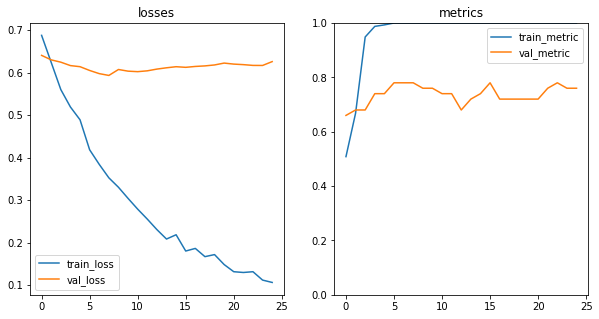

  training loss (in-iteration): 	0.106279
  validation loss: 			0.625981

  training AUC: 			1.00
  validation AUC: 			0.76


In [80]:
dataset.use_sources = ["USM"]

# dataset have target classes 1 and 2
# encode target with LabelEncoder to use classes 0 and 1 instead
dataset.set_target("DX_GROUP", encode_target=True)

notnull_idx = dataset.target[dataset.target.notnull()].index
train_idx, val_idx = train_test_split(notnull_idx, stratify=dataset.target[notnull_idx],
                                      test_size=0.2, random_state=42)
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    data.Subset(dataset, train_idx), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    data.Subset(dataset, val_idx), batch_size=batch_size, shuffle=False)

C_model = ConvEncoder(input_shape=(48, 64, 48), 
                      conv_model=[32, 64, 128, 256], 
                      conv_model_type="CNN",
                      n_flatten_units=None).to(device)
T_model = ClfGRU(n_latent_units=C_model.conv_model.n_flatten_units, 
                 seq_length=16, 
                 n_outputs=2,
                 hidden_size=64,
                 n_layers=1,
                 use_states="mean",
                 n_fc_units=128,
                 dropout=0.2).to(device)
lr = 1e-4
wd = 0           
C_opt = torch.optim.Adam(C_model.parameters(), lr=lr, weight_decay=wd)
T_opt = torch.optim.Adam(T_model.parameters(), lr=lr, weight_decay=wd)

args = {"n_epochs" : 25}
train_stats = train(train_loader, val_loader, args,
                    C_model, T_model, C_opt, T_opt,
                    crit=nn.CrossEntropyLoss(), metric=roc_auc_score)

EPOCH 24


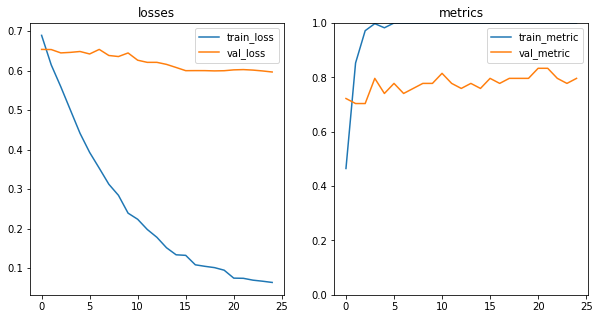

  training loss (in-iteration): 	0.063626
  validation loss: 			0.596836

  training AUC: 			1.00
  validation AUC: 			0.80


In [82]:
# train on the data from UCLA only
dataset.use_sources = ["UCLA"]

# dataset have target classes 1 and 2
# encode target with LabelEncoder to use classes 0 and 1 instead
dataset.set_target("DX_GROUP", encode_target=True)

notnull_idx = dataset.target[dataset.target.notnull()].index
train_idx, val_idx = train_test_split(notnull_idx, stratify=dataset.target[notnull_idx],
                                      test_size=0.2, random_state=42)
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    data.Subset(dataset, train_idx), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    data.Subset(dataset, val_idx), batch_size=batch_size, shuffle=False)

C_model = ConvEncoder(input_shape=(48, 64, 48), 
                      conv_model=[32, 64, 128, 256], 
                      conv_model_type="CNN",
                      n_flatten_units=None).to(device)
T_model = ClfGRU(n_latent_units=C_model.conv_model.n_flatten_units, 
                 seq_length=16, 
                 n_outputs=2,
                 hidden_size=64,
                 n_layers=1,
                 use_states="mean",
                 n_fc_units=128,
                 dropout=0.2).to(device)
lr = 1e-4
wd = 0           
C_opt = torch.optim.Adam(C_model.parameters(), lr=lr, weight_decay=wd)
T_opt = torch.optim.Adam(T_model.parameters(), lr=lr, weight_decay=wd)

args = {"n_epochs" : 25}
train_stats = train(train_loader, val_loader, args,
                    C_model, T_model, C_opt, T_opt,
                    crit=nn.CrossEntropyLoss(), metric=roc_auc_score)

EPOCH 24


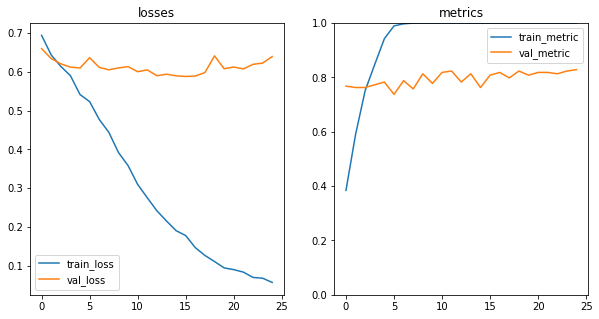

  training loss (in-iteration): 	0.056803
  validation loss: 			0.639335

  training AUC: 			1.00
  validation AUC: 			0.83


In [83]:
# train on the data from USM+UCLA
dataset.use_sources = ["USM", "UCLA"]

# dataset have target classes 1 and 2
# encode target with LabelEncoder to use classes 0 and 1 instead
dataset.set_target("DX_GROUP", encode_target=True)

notnull_idx = dataset.target[dataset.target.notnull()].index
train_idx, val_idx = train_test_split(notnull_idx, stratify=dataset.target[notnull_idx],
                                      test_size=0.2, random_state=42)
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    data.Subset(dataset, train_idx), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    data.Subset(dataset, val_idx), batch_size=batch_size, shuffle=False)

C_model = ConvEncoder(input_shape=(48, 64, 48), 
                      conv_model=[32, 64, 128, 256], 
                      conv_model_type="CNN",
                      n_flatten_units=None).to(device)
T_model = ClfGRU(n_latent_units=C_model.conv_model.n_flatten_units, 
                 seq_length=16, 
                 n_outputs=2,
                 hidden_size=64,
                 n_layers=1,
                 use_states="mean",
                 n_fc_units=128,
                 dropout=0.2).to(device)
lr = 1e-4
wd = 0           
C_opt = torch.optim.Adam(C_model.parameters(), lr=lr, weight_decay=wd)
T_opt = torch.optim.Adam(T_model.parameters(), lr=lr, weight_decay=wd)

args = {"n_epochs" : 25}
train_stats = train(train_loader, val_loader, args,
                    C_model, T_model, C_opt, T_opt,
                    crit=nn.CrossEntropyLoss(), metric=roc_auc_score)

### Latent reprsentations

Now, let's take a look at the latent features learnt by convolutional model.

In [94]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

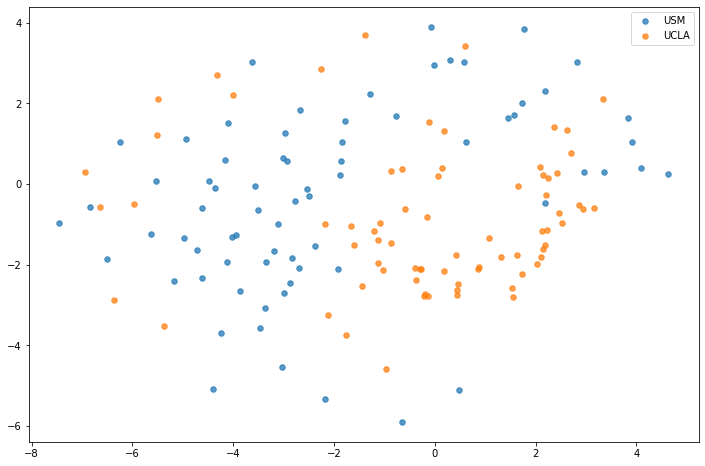

In [109]:
latents = []
dataset.set_target()
C_model.train(False)
for i in tqdm(notnull_idx):
    x = dataset[i][[0]].unsqueeze(dim=0).to(device)
    z = C_model(x)[0].cpu().detach().numpy()
    latents.append(z)
latents = np.concatenate(latents, axis=0)

pca = PCA(n_components=50)
tsne = TSNE(n_components=2)
latents_2d = tsne.fit_transform(pca.fit_transform(latents))

source_colors = {"USM" : "tab:blue",
          "UCLA" : "tab:orange",}
sources = np.array(dataset.labels.loc[notnull_idx, "SOURCE"].tolist())

plt.figure(figsize=(12, 8))
for s in source_colors:
    s_idx = (sources == s)
    plt.scatter(latents_2d[s_idx, 0], latents_2d[s_idx, 1], 
                s=30, alpha=0.75, c=source_colors[s], label=s)
plt.legend()
plt.show()

## 3. Domain adaptation

Let's try to make the model encode **less site-dependent** information.

We will employ one of the most widespread domain adaptation approaches proposed by Ganin et al. [https://arxiv.org/pdf/1505.07818.pdf]. The model here is composed of 3 parts: 
- a **feature extractor**, that transforms an input (in our case, an fMRI image) into a vector of high-level features,
- a **classifier (predictor)** - the main model, that takes extracted features and predicts the target;
- a **discriminator**, that takes extracted features and predicts the **domain** on the original sample. 

During optimization, the gradients from discriminator to feature extractor are **reversed**. So, the feature extractor is forced to learn the features, that are **as less informative as possible** for the discriminator, that is, contain **less information on the domain**. 


The whole architecture is presented below:
<img src="https://miro.medium.com/max/1082/1*9aVg6JGcZFSKHUn_U4RrUQ.png">


### Discriminator for DANN

As a discriminator we will use a simple model that takes feature vector of each time step, applies fully-connected network to it to predict probability of each class (domain) and then averages the predcitions.

In [110]:
# discriminator to predict domain (site) of a sample
class DiscModel(nn.Module):
    def __init__(self, n_latent_units, 
                 n_domains=2,
                 fc_model=[1024, 256, 64], 
                 batchnorm=True,
                 dropout=0):
        super(self.__class__, self).__init__()
        self.n_latent_units = n_latent_units
        self.n_outputs = n_domains

        self.model = []
        n_in = n_latent_units
        for n_out in fc_model:
            self.model += [nn.Dropout(dropout),
                           nn.Linear(n_in, n_out)]
            if batchnorm:
                self.model += [nn.BatchNorm1d(n_out)]
            self.model += [
                nn.ReLU(True),
            ]
            n_in = n_out
        self.model += [nn.Dropout(dropout),
                       nn.Linear(n_in, self.n_outputs)]
        self.model = nn.Sequential(*self.model)

                    
    def forward(self, x): 
        # reshape to (n_obj * n_time_steps, latent_size)
        n_objects, seq_length = x.size()[0:2]
        x = x.reshape([n_objects * seq_length] + list(x.size()[2:]))
        # apply fc model
        x = self.model(x)
        # reshape to (n_obj, n_time_steps, logit), mean over time_steps
        x = x.reshape([n_objects, seq_length, -1])
        x = x.mean(dim=1)
        return x

### DANN train functions

In [77]:
def train_DA(train_loader, val_loader, args,
             C, T, D, C_opt, T_opt, D_opt,
             crit=nn.CrossEntropyLoss(), D_crit=nn.BCEWithLogitsLoss(),
             metric=roc_auc_score):
    
    def plot_results(epoch):
        clear_output(True)
        print("EPOCH {}".format(epoch))
        
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.plot(train_stats["mean_train_loss"], label="train_loss")
        plt.plot(train_stats["mean_val_loss"], label="val_loss")
        plt.plot(train_stats["mean_total_loss"], label="total_loss")
        plt.plot(train_stats["mean_D_loss"], label="D_loss")
        plt.title("losses")
        plt.legend()
        plt.subplot(122)
        plt.plot(train_stats["mean_train_metric"], label="train_metric")
        plt.plot(train_stats["mean_val_metric"], label="val_metric")
        plt.gca().set_ylim([0, 1])
        plt.title("metricss")
        plt.legend()
        plt.show()
        
        print("  training D_loss (in-iteration): \t{:.6f}".format(train_stats["mean_D_loss"][-1]))
        print("  training total_loss (in-iteration): \t{:.6f}".format(train_stats["mean_total_loss"][-1]))
        print("  training loss (in-iteration): \t{:.6f}".format(train_stats["mean_train_loss"][-1]))
        print("  validation loss: \t\t\t{:.6f}".format(train_stats["mean_val_loss"][-1]))
        print()
        print("  training AUC: \t\t\t{:.2f}".format(train_stats["mean_train_metric"][-1]))
        print("  validation AUC: \t\t\t{:.2f}".format(train_stats["mean_val_metric"][-1]))
    
    train_stats = {
        "mean_D_loss" : [],
        "mean_total_loss" : [],
        "mean_train_loss" : [],
        "mean_val_loss" : [],
        "mean_train_metric" : [],
        "mean_val_metric" : [],
    }
    
    for epoch in range(args["n_epochs"]):
        print("TRAIN EPOCH {}...".format(epoch))
        train_D_loss = []
        train_loss, train_total_loss, train_preds, train_targets = [], [], [], []
        val_loss, val_preds, val_targets = [], [], []
        
        D_n_upd = args["D_n_upd"] if epoch < args["D_loop_epochs"] else 1
        if epoch <= args["n_pretr_epochs"]:
            cur_lambda = args["min_lambda"]
        elif cur_lambda < args["max_lambda"]:
            cur_lambda += args["inc_lambda"]
        else: 
            cur_lambda = args["max_lambda"]
        print(f"Current lambda: {cur_lambda}")
        
        C.train(True), T.train(True), D.train(True)
        for inputs_batch, targets_batch, domains_batch in tqdm(train_loader):
            domains_batch = torch.zeros((len(domains_batch), args["n_domains"])).scatter(1, domains_batch.view(-1, 1), 1)
            inputs_batch, targets_batch, domains_batch = inputs_batch.float().to(device), targets_batch.long().to(device), domains_batch.float().to(device)

            # train D
            latents_batch = C(inputs_batch)
            for _ in range(D_n_upd):
                D_logits_batch = D(latents_batch.detach())
                D_loss = D_crit(D_logits_batch, domains_batch)
                D_opt.zero_grad()
                D_loss.backward()
                D_opt.step()
            train_D_loss.append(D_loss.item())
            
            # train C & T
            latents_batch = C(inputs_batch)
            logits_batch = T(latents_batch)
            loss = crit(logits_batch, targets_batch)
            D_logits_batch = D(latents_batch)
            D_loss = D_crit(D_logits_batch, 1 - domains_batch)
            total_loss = loss + cur_lambda * D_loss
            total_loss.backward()
            T_opt.step(), C_opt.step()
            T_opt.zero_grad(), C_opt.zero_grad()
            
            train_loss.append(loss.item())
            train_total_loss.append(total_loss.item())
            preds = compute_probs(logits_batch)
            train_preds.extend(list(preds.cpu().data.numpy()))
            train_targets.extend(list(targets_batch.cpu().data.numpy()))
        train_metric = metric(train_targets, train_preds)
        
        C.train(False), T.train(False)
        for inputs_batch, targets_batch, domains_batch in tqdm(val_loader):
            inputs_batch, targets_batch, domains_batch = inputs_batch.float().to(device), targets_batch.long().to(device), domains_batch.float().to(device)
            
            latents_batch = C(inputs_batch)
            logits_batch = T(latents_batch)
            loss = crit(logits_batch, targets_batch)
            val_loss.append(loss.item())
            preds = compute_probs(logits_batch)
            val_preds.extend(list(preds.cpu().data.numpy()))
            val_targets.extend(list(targets_batch.cpu().data.numpy())) 
        val_metric = metric(val_targets, val_preds)

        # save stats
        train_stats["mean_D_loss"].append(np.mean(train_D_loss))
        train_stats["mean_total_loss"].append(np.mean(train_total_loss))
        train_stats["mean_train_loss"].append(np.mean(train_loss))
        train_stats["mean_val_loss"].append(np.mean(val_loss))
        train_stats["mean_train_metric"].append(train_metric)
        train_stats["mean_val_metric"].append(val_metric)
        
        plot_results(epoch)        
    return train_stats

### Training

In [ ]:
dataset.use_sources = ["USM", "UCLA"]

# dataset have target classes 1 and 2
# encode target with LabelEncoder to use classes 0 and 1 instead
# also set the domain target column ("SOURCE")
dataset.set_target("DX_GROUP", encode_target=True, domain_target="SOURCE")

notnull_idx = dataset.target[dataset.target.notnull()].index
train_idx, val_idx = train_test_split(notnull_idx, stratify=dataset.target[notnull_idx],
                                      test_size=0.2, random_state=42)
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    data.Subset(dataset, train_idx), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    data.Subset(dataset, val_idx), batch_size=batch_size, shuffle=False)

C_model = ConvEncoder(input_shape=(48, 64, 48), 
                      conv_model=[32, 64, 128, 256], 
                      conv_model_type="CNN",
                      n_flatten_units=None).to(device)
T_model = ClfGRU(n_latent_units=C_model.conv_model.n_flatten_units, 
                 seq_length=16, 
                 n_outputs=2,
                 hidden_size=64,
                 n_layers=1,
                 use_states="mean",
                 n_fc_units=128,
                 dropout=0.2,).to(device)
D_model = DiscModel(n_latent_units=C_model.conv_model.n_flatten_units, 
                    n_domains=len(dataset.use_sources),
                    fc_model=[1024, 256, 64],
                    batchnorm=True,
                    dropout=0.3).to(device)
lr = 1e-4
wd = 0           
C_opt = torch.optim.Adam(C_model.parameters(), lr=lr, weight_decay=wd)
T_opt = torch.optim.Adam(T_model.parameters(), lr=lr, weight_decay=wd)
D_opt = torch.optim.Adam(D_model.parameters(), lr=lr, weight_decay=wd)

args = {
    "n_domains" : len(dataset.use_sources),
    "n_epochs" : 25,
    "n_pretr_epochs" : 0,
    "min_lambda" : 0,
    "inc_lambda" : 3e-4 / 20,
    "max_lambda" : 3e-4,
    "D_loop_epochs" : 15,
    "D_n_upd" : 3,
}

train_stats = train_DA(train_loader, val_loader, args,
                       C_model, T_model, D_model, C_opt, T_opt, D_opt)

In [ ]:
latents = []
dataset.set_target()
C_model.train(False)
for i in tqdm(notnull_idx):
    x = dataset[i][[0]].unsqueeze(dim=0).to(device)
    z = C_model(x)[0].cpu().detach().numpy()
    latents.append(z)
latents = np.concatenate(latents, axis=0)

pca = PCA(n_components=50)
tsne = TSNE(n_components=2)
latents_2d = tsne.fit_transform(pca.fit_transform(latents))

source_colors = {"USM" : "tab:blue",
          "UCLA" : "tab:orange",}
sources = np.array(dataset.labels.loc[notnull_idx, "SOURCE"].tolist())

plt.figure(figsize=(12, 8))
for s in source_colors:
    s_idx = (sources == s)
    plt.scatter(latents_2d[s_idx, 0], latents_2d[s_idx, 1], 
                s=30, alpha=0.75, c=source_colors[s], label=s)
plt.legend()
plt.show()